# Lemmatizing with CLTK

Let's investigate to what degree speeches that come second in a conversation re-use the language of the speech to which they reply.

## Preliminaries

### A couple of useful packages

In [1]:
import random
import re

### The DICES API

In [2]:
from dicesapi import DicesAPI
from dicesapi.jupyter import NotebookPBar
api = DicesAPI(progress_class=NotebookPBar, logfile='dices.log')

### CLTK parsing pipelines

CLTK uses language-specific NLP pipelines. I like to stick them in a dictionary keyed to the speeches' language codes, so I can use the same expressions regardless of language.

In [3]:
from cltk.nlp import NLP

cltk_nlp = {
    'greek': NLP('grc', suppress_banner=True),
    'latin': NLP('lat', suppress_banner=True),    
}

By default, these pipelines are pretty full-featured, including NER and stoplist dictionaries; the Latin one also includes definitions from Lewis and Short for every token. If you don’t need the extras, paring the pipelines back to just lemmatization improves speed significantly.

In [4]:
cltk_nlp['greek'].pipeline.processes = cltk_nlp['greek'].pipeline.processes[:2]
cltk_nlp['latin'].pipeline.processes = cltk_nlp['latin'].pipeline.processes[:2]

## Process the speeches

### Query the DICES API

For the moment, at least, it’s generally easier to download an inclusive set of speeches from the remote server all at once, then filter them locally using the client library. Here, we download all speeches in Homer. 

<div class="alert alert-warning" style="margin: 1em 2em">
    <p>We could have used <code>author_name='Homer'</code> as the sole search param, but for now that also includes the Homeric Hymns. And this way we can showcase concatenation of results with the <code>+</code> operator.</p>
</div>

In [5]:
speeches = api.getSpeeches(work_title='Iliad', progress=True) + \
            api.getSpeeches(work_title='Odyssey', progress=True)
speeches.sort()

### Download the text of the speeches

Before we can do any NLP, we have to get the text of the speeches from the remote library. In this loop, we download the CTS passage for each speech in turn, appending the plain text of the passage to the respective speech object as a new attribute.

In [6]:
# create a progress bar
pbar = NotebookPBar(max=len(speeches))

# download text, add to speech object as new attribute
for s in speeches:
    s.cts_passage = s.getCTS()
    if s.cts_passage is None:
        print(s)
    pbar.update()

<Speech 931: Odyssey 10.456-10.465>


### Parse the speech text with CLTK

Now we can run CLTK’s NLP pipelines, using the wrapper function defined above. The pipeline function returns a object containing the results of all processes included in the pipeline. I’m this object as a new attribute of the speech being processed—I’ll call it `.cltk_doc`.

In [7]:
# create a progress bar
pbar = NotebookPBar(start=0, max=len(speeches))

# iterate over speeches
for s in speeches:
    pbar.update()
    lang = s.work.lang
    
    if hasattr(s, 'cltk_doc'):
        continue
    
    if s.cts_passage is None:
        s.cltk_doc = None
    else:
        s.cltk_doc = cltk_nlp[s.work.lang](s.cts_passage.text)

## Looking for shared lemmata

Now that we've got the raw data, let's try a simple experiment: **To what extent do replies reuse language from the speech they're replying to?**

For this test:

1. We'll consider as replies those speeches that come second in their conversation, i.e. `part==2`.
2. We'll measure language reuse as lemmata shared between part 1 and part 2 of a speech cluster, as a fraction of the lemmata in part 1. We'll count only distinct *types*, that is, duplicate lemmata in a single speech won't be counted.
3. To estimate how much overlap we might expect by chance, we'll also compare reply speeches to some randomly selected initial speeches from unrelated conversations.

### Replies

First, let's gather all speeches whose `part` attribute is `2`.

In [8]:
# filter by part
replies = speeches.filterParts([2])

# how many results?
print(len(replies))

279


### Incipits

Now, let's gather all speeches whose `part` is `1`.

In [9]:
# filter by part
incipits = speeches.filterParts([1])

# how many results
print(len(incipits))

660


There are a lot more initial speeches than replies because so many speech clusters only have a single speech. Let's further limit the incipits under consideration to those from clusters represented in `replies`:

In [10]:
incipits = incipits.filterClusters(replies.getClusters())
len(incipits)

279

I want to organize these two groups in two different ways. In one treatment, each reply is paired with its incipit. In the control, each reply is paired with a random incipit.

### Incipit-reply matched pairs

Let's try pairing them off, first, and see what happens:

In [11]:
# start with empty list
reply_pairs = []

# check each reply
for reply in replies:

    # get incipits with same cluster id
    results = incipits.filterClusters([reply.cluster])
    
    # should be only one
    if len(results) == 0:
        print(f'found no incipit for cluster {reply.cluster.id}')
    elif len(results) > 1:
        print(f'found {len(results)} incipits for cluster {reply.cluster.id}')
    else:
        reply_pairs.append((results[0], reply))
        

# how many pairs?
print(len(reply_pairs))

279


### Randomized control set

Now let's shuffle the incipits and replies to create some control pairs.

In [12]:
# start with empty list
random_pairs = []

# choose incipts, replies at random
while len(random_pairs) < len(reply_pairs):
    i = random.randint(0, len(incipits)-1)
    j = random.randint(0, len(replies)-1)
    if incipits[i].cluster.id != replies[j].cluster.id:
        random_pairs.append((incipits[i], replies[j]))

# how many pairs?
print(len(random_pairs))

279


### Metric for shared lemmata

For a given pair of speeches, one incipit and one reply, we're looking for the number of unique, shared lemmata divided by the number of unique lemmata in the incipit alone.

First, we'll write a custom function to return the shared lemmata. I'm going to omit punctuation, which we can filter out on the `upos` attribute—this is a so-called [Universal Part of Speech](https://universaldependencies.org/u/pos/) tag, which should be comparable between Latin and Greek, and is `'PUNCT'` for punctuation marks in both languages.

In [13]:
def shared(speech_a, speech_b):
    '''Return shared lemmata between two speeches'''
    
    lems_a = [w.lemma for w in speech_a.cltk_doc if w.upos != 'PUNCT']
    lems_b = [w.lemma for w in speech_b.cltk_doc if w.upos != 'PUNCT']
    
    shared = set([lem for lem in lems_a if lem in lems_b])
        
    return shared

### Comparison of incipit-reply pairs to randomized control

Now we just run through our two groups of pairs, and calculate the metric for each group.

In [14]:
# start with empty list
nshared_reply = []

# calculate for matched pairs
for incipit, reply in reply_pairs:
    total_lems_incipit = len(set([w.lemma for w in incipit.cltk_doc]))
    nshared_reply.append(len(shared(incipit, reply))/total_lems_incipit)

# how many values?
print(len(nshared_reply))

279


In [15]:
# start with empty list
nshared_random = []

# calculate for matched pairs
for incipit, reply in random_pairs:
    total_lems_incipit = len(set([w.lemma for w in incipit.cltk_doc]))
    nshared_random.append(len(shared(incipit, reply))/total_lems_incipit)

# how many values?
print(len(nshared_random))

279


### Visualize results

Are the two groups similar? Let's use a simply box and whisker plot to get an overview of the distributions.

In [16]:
from matplotlib import pyplot
%matplotlib inline

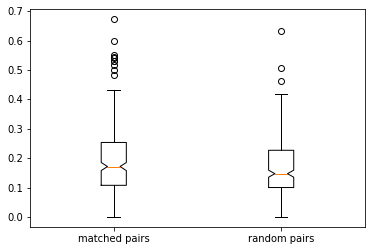

In [17]:
pyplot.boxplot([nshared_reply, nshared_random], notch=True, labels=['matched pairs', 'random pairs'])
pyplot.show()

### Digging a little deeper...

Well, the results are suggestive, but how significant are they. One way forward might be a statistical analysis of the distributions of this metric in the two groups.

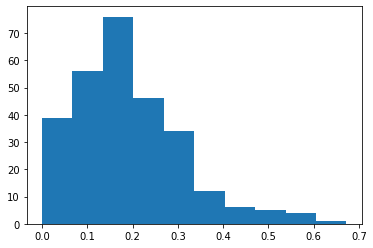

In [18]:
pyplot.hist(nshared_reply)
pyplot.show()

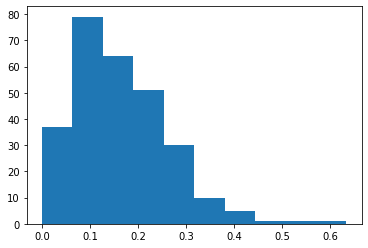

In [19]:
pyplot.hist(nshared_random)
pyplot.show()

In [20]:
import scipy.stats
scipy.stats.ttest_ind(nshared_reply, nshared_random)

Ttest_indResult(statistic=2.810535681367659, pvalue=0.00512021250617286)